## Unequal Game solution with CCEM method

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import clear_output

Let's find guaranteed result


\begin{gather*}
\begin{cases}
t_0 = 0, \\
x_0 = 1,\\
x_n = x_{n-1} + (u(t_{n-1}, x_{n-1}) - v(t_{n-1}, x_{n-1})) \cdot dt;
\end{cases}\\\\
x_n = 1 + \sum_{i=0}^{n-1}(u(t_i, x_i) - v(t_i, x_i)) \cdot dt = 1 + (U - V)  dt, \\u_i := u(t_i, x_i), \quad v_i := v(t_i, x_i), \quad i = \overline{0, n-1}\\ \\
R(u_0, \ldots, u_{n-1}, v_0, \ldots v_{n-1}) = R(U, V) = \left(1 + (U - V)  dt\right)^2.
\end{gather*}


\begin{gather*}
\gamma^{v} = \max_{V}\min_{U} R(U, V), \\\\
\frac{\partial}{\partial U}R = 2 (1 + (U-V)dt) dt = 0 \; \Longrightarrow \; U - V = -\dfrac{1}{dt}, \\
\min_{U} R(U, V) = \left(1 -\dfrac{1}{dt} dt\right)^2 = 0  \; \Longrightarrow \; \gamma^{v} = 0
\end{gather*}

\begin{gather*}
\gamma^u = \min_{U}\max_{V} R(U, V), \\\\
\max_{V} R(U, V) = \max\left\{ R(U, n), R(U, -n)\right\}, \\
R(U, n) - R(U, -n) = (1 + (U-n)dt)^2 - (1+(U+n)dt)^2 = - 4ndt(1+Udt), \\\\
n = \dfrac{2}{dt}, \quad |U| \leqslant 2n = \dfrac{4}{dt},\\\\
\max_{V} R(U, V) = R(U, n) \;\Longrightarrow\;  U \leqslant -\dfrac{1}{dt}, \\
\frac{\partial}{\partial U}R = 2 (1 + (U-n)dt) dt = 0 \; \Longrightarrow \; U  = n - \dfrac{1}{dt} = \dfrac{1}{dt} \notin \left[-\dfrac{4}{dt}, -\dfrac{1}{dt}\right]\; \Longrightarrow \; \gamma^{u} =\min_U(R, n) = \\=\min\left\{R\left(-\dfrac{4}{dt}, n\right), R\left(-\dfrac{1}{dt}, n\right)\right\} = 16, \\\\
\max_{V} R(U, V) = R(U, -n) \;\Longrightarrow\;  U \geqslant -\dfrac{1}{dt}, \\
\frac{\partial}{\partial U}R = 2 (1 + (U+n)dt) dt = 0 \; \Longrightarrow \; U  = -n - \dfrac{1}{dt} = -\dfrac{3}{dt} \notin \left[-\dfrac{1}{dt}, \dfrac{4}{dt}\right]\; \Longrightarrow \; \gamma^{u} =\min_U(R, n) = \\=\min\left\{R\left(-\dfrac{1}{dt}, -n\right), R\left(\dfrac{4}{dt}, -n\right)\right\} = 4, \\\\
\end{gather*}

Implement environment

In [0]:
class UnequalGame:

    def __init__(self, initial_x=1, dt=0.005, terminal_time=2, u_action_max=2, v_action_max=1):
        self.u_action_max = u_action_max
        self.v_action_max = v_action_max
        self.terminal_time = terminal_time
        self.dt = dt
        self.initial_x = initial_x
        self.state = self.reset()

    def reset(self):
        self.state = np.array([0, self.initial_x])
        return self.state

    def step(self, u_action, v_action):
        t, x = self.state
        x = x + (u_action - v_action) * self.dt
        t += self.dt
        self.state = np.array([t, x])

        reward = 0
        done = False
        if t >= self.terminal_time:
            reward = x ** 2
            done = True

        return self.state, reward, done, None


Implement agent

In [0]:
class Network(torch.nn.Module):

    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.linear_1 = torch.nn.Linear(input_shape[0], 50)
        self.linear_2 = torch.nn.Linear(50, 30)
        self.linear_3 = torch.nn.Linear(30, output_shape[0])
        self.relu = torch.nn.ReLU()
        self.tang = torch.nn.Tanh()

    def forward(self, input_):
        hidden = self.relu(self.linear_1(input_))
        hidden = self.relu(self.linear_2(hidden))
        output = self.tang(self.linear_3(hidden))
        return output


class CCEMAgent(torch.nn.Module):

    def __init__(self, state_shape, action_shape, action_max, reward_param=1, percentile_param=70, noise_decrease=0.98,
                 tau=1e-2, learning_rate=1e-2, n_learning_per_fit=16):
        super().__init__()
        self.action_max = np.abs(action_max)
        self.reward_param = reward_param  # equal to 1 if agent wants to maximize reward otherwise -1
        self.percentile_param = percentile_param
        self.noise_decrease = noise_decrease
        self.noise_threshold = 1
        self.min_noise_threshold = 0.1
        self.tau = tau
        self.n_learning_per_fit = n_learning_per_fit
        self.network = Network(state_shape, action_shape)
        self.optimizer = torch.optim.Adam(params=self.network.parameters(), lr=learning_rate)

    def get_action(self, state, test=False):
        state = torch.FloatTensor(state)
        predicted_action = self.network(state).detach().numpy() * self.action_max
        if not test:
            noise = self.noise_threshold * np.random.uniform(low=-self.action_max, high=self.action_max)
            predicted_action = np.clip(predicted_action + noise, -self.action_max, self.action_max)
        return predicted_action

    def get_elite_states_and_actions(self, sessions, prefix):
        """
          Select sessions with the most or least reward
          by percentile
        """
        total_rewards = [session['total_reward'] for session in sessions]
        reward_threshold = np.percentile(total_rewards, self.percentile_param)

        elite_states = []
        elite_actions = []
        for session in sessions:
            if self.reward_param * (session['total_reward'] - reward_threshold) > 0:
                elite_states.extend(session['states'])
                elite_actions.extend(session[f'{prefix}actions'])

        return torch.FloatTensor(elite_states), torch.FloatTensor(elite_actions)

    def learn_network(self, loss):
        self.optimizer.zero_grad()
        old_network = deepcopy(self.network)
        loss.backward()
        self.optimizer.step()

        for new_parameter, old_parameter in zip(self.network.parameters(), old_network.parameters()):
            new_parameter.data.copy_((1 - self.tau) * new_parameter + self.tau * old_parameter)

        return None

    def fit(self, sessions, prefix=''):
        elite_states, elite_actions = self.get_elite_states_and_actions(sessions, prefix=prefix)

        for _ in range(self.n_learning_per_fit):
            predicted_action = self.network(elite_states) * self.action_max
            loss = torch.mean((predicted_action - elite_actions) ** 2)
            self.learn_network(loss)

        if self.noise_threshold > self.min_noise_threshold:
            self.noise_threshold *= self.noise_decrease

        return None


Train agents

In [0]:
def generate_session(u_agent, v_agent, env, t_max=200, test=False):
    """
    Generate session on environment with agent
    """
    states = []
    u_actions = []
    v_actions = []
    total_reward = 0
    done = False
    state = env.reset()
    while not done:
        u_action = u_agent.get_action(state, test=test)
        v_action = v_agent.get_action(state)
        next_state, reward, done, _ = env.step(u_action[0], v_action[0])
        states.append(state)
        u_actions.append(u_action)
        v_actions.append(v_action)
        total_reward += reward
        state = next_state

    return {'states': states, 'u_actions': u_actions, 'v_actions': v_actions, 'total_reward': total_reward}


def train_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon, test=False):
    last_mean_reward = 0
    mean_rewards = []
    
    for epoch in range(n_epochs):
        sessions = [generate_session(u_agent, v_agent, env, test=test) for _ in range(n_sessions)]
        mean_reward = np.mean([session['total_reward'] for session in sessions])
        if not test:
            u_agent.fit(sessions, prefix='u_')
        v_agent.fit(sessions, prefix='v_')
        mean_rewards.append(mean_reward)
        print('epoch: {0}, mean reward: {1}'.format(epoch, mean_reward))
        # if epoch > 0:
        #    clear_output(True)
        #    plt.plot(range(len(mean_rewards)), mean_rewards)
        #    plt.show()
        if np.abs(last_mean_reward - mean_reward) < epsilon:
            break
        last_mean_reward = mean_reward
        
    return np.array(mean_rewards)

In [0]:
env = UnequalGame()
u_agent = CCEMAgent((2,), (1,), percentile_param=30, action_max=env.u_action_max, reward_param=-1)
v_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)
n_epochs = 100
n_sessions = 100
epsilon = 1e-5

In [20]:
mean_rewards = train_agents(u_agent, v_agent, env, n_epochs, n_sessions, epsilon)

epoch: 0, mean reward: 0.9156154269240314
epoch: 1, mean reward: 0.7644831524449275
epoch: 2, mean reward: 0.5949017058527144
epoch: 3, mean reward: 0.5019466916070694
epoch: 4, mean reward: 0.50183913292839
epoch: 5, mean reward: 0.4566588029175106
epoch: 6, mean reward: 0.3818096642823231
epoch: 7, mean reward: 0.2511504527976463
epoch: 8, mean reward: 0.16976311198758373
epoch: 9, mean reward: 0.10442770059189126
epoch: 10, mean reward: 0.06891049975526842
epoch: 11, mean reward: 0.055996683197760584
epoch: 12, mean reward: 0.04449200782884373
epoch: 13, mean reward: 0.03751272699150623
epoch: 14, mean reward: 0.03069495578803292
epoch: 15, mean reward: 0.024037627070974912
epoch: 16, mean reward: 0.013135946629120878
epoch: 17, mean reward: 0.007056874610279694
epoch: 18, mean reward: 0.0056698430294592735
epoch: 19, mean reward: 0.004083813714067913
epoch: 20, mean reward: 0.0022004943589138543
epoch: 21, mean reward: 0.0019210538323194285
epoch: 22, mean reward: 0.001989903129880

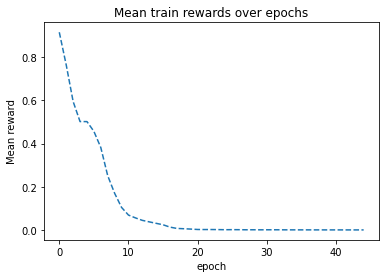

In [26]:
plt.plot(range(len(mean_rewards)), mean_rewards, '--')
plt.xlabel('epoch')
plt.ylabel('Mean reward')
plt.title('Mean train rewards over epochs')
plt.show()

Test u_gent

In [0]:
v_test_agent = CCEMAgent((2,), (1,), percentile_param=70, action_max=env.v_action_max, reward_param=1)

In [23]:
test_rewards = train_agents(u_agent, v_test_agent, env, n_epochs, n_sessions, epsilon, test=True)

epoch: 0, mean reward: 0.013536622434659116
epoch: 1, mean reward: 0.014804375017348735
epoch: 2, mean reward: 0.01754110201968003
epoch: 3, mean reward: 0.020370495405664414
epoch: 4, mean reward: 0.024582105093423078
epoch: 5, mean reward: 0.029184630919047935
epoch: 6, mean reward: 0.034751006429969304
epoch: 7, mean reward: 0.03906564911419606
epoch: 8, mean reward: 0.04312437131728695
epoch: 9, mean reward: 0.04536121065696838
epoch: 10, mean reward: 0.04704104433222559
epoch: 11, mean reward: 0.04905834729466361
epoch: 12, mean reward: 0.05022495288155104
epoch: 13, mean reward: 0.05330095706337223
epoch: 14, mean reward: 0.05361002146974315
epoch: 15, mean reward: 0.055631552793459944
epoch: 16, mean reward: 0.056130619853933465
epoch: 17, mean reward: 0.05786182925021827
epoch: 18, mean reward: 0.05931530245792843
epoch: 19, mean reward: 0.06139010514956698
epoch: 20, mean reward: 0.06260443026969864
epoch: 21, mean reward: 0.06313124804045804
epoch: 22, mean reward: 0.06500989

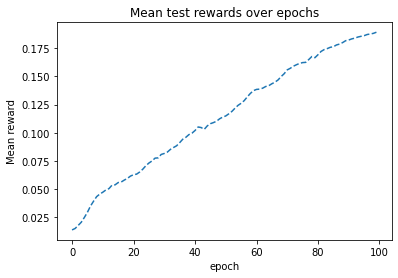

In [25]:
plt.plot(range(len(test_rewards)), test_rewards, '--')
plt.xlabel('epoch')
plt.ylabel('Mean reward')
plt.title('Mean test rewards over epochs')
plt.show()